<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#6A0DAD; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [Introduction](#1)
* [Import and Pre-Processing](#2)
* [Build and Train model](#3)
* [Evaluate Model](#4)

<a id="1"></a>
<h3 style='background:#6A0DAD; border:0; color:white'><center>Introduction<center><h3>

**CIFAR-100** is a dataset that contains 60,000 color images of 32x32 pixels with 3 channels, the dataset contains 20 superclasses and 100 object classes. The training dataset contains 50,000 images and the test dataset contains 10,000 images. More information on the dataset can be obtained from the link: https://www.cs.toronto.edu/~kriz/cifar.html

This notebook provides a baseline for solving the problem of multi-label classification using Transfer Learning with Convolutional Neural Network in TensorFlow.

Several images of bicycles from Google Search are used to predict the trained model.

<a id="2"></a>
<h3 style='background:#6A0DAD; border:0; color:white'><center>Import and Pre-Processing<center><h3>

In [1]:
# Importing the required libraries and dataset
import os
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide all TensorFlow debugging logs

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Load dataset and pre-process data (Total data -> train and test)
# In CIFAR-100, 50000 train + 10000 test
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize the images (0 to 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
X_train

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.76470588, 0.80392157, 0.75686275],
         [0.83137255, 0.87843137, 0.8       ],
         [0.71372549, 0.76078431, 0.65490196]],

        [[1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.66666667, 0.69019608, 0.58823529],
         [0.63137255, 0.65882353, 0.50980392],
         [0.57254902, 0.60392157, 0.44313725]],

        [[1.        , 1.        , 1.        ],
         [0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ],
         ...,
         [0.74117647, 0.78039216, 0.6627451 ],
         [0.65098039, 0.69803922, 0.50980392],
         [0.4745098 , 0.52156863, 0.34117647]],

        ...,

        [[0.58039216, 0.7254902 , 0.30980392],
         [0.55686275, 0.71372549, 0.22352941]

In [6]:
y_train

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [8]:
# Split the data into test and validation data
# test -> val and test (0.7 as test set)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [9]:
# Dataset class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [17]:
y_train[2]

array([0])

In [18]:
y_train[2].astype(int)[0]

0

In [19]:
labels[y_train[2].astype(int)[0]]

'apple'

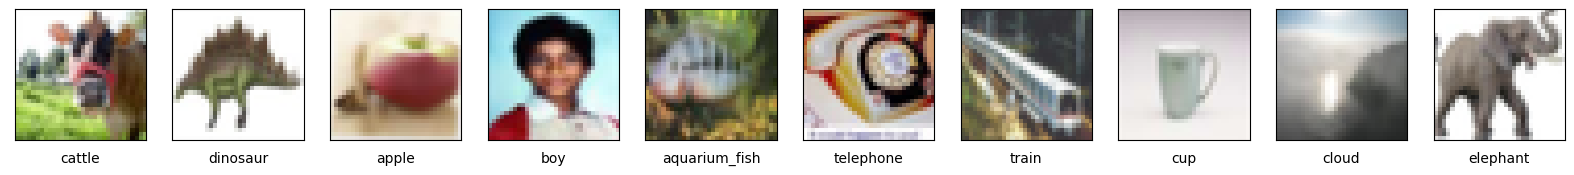

In [20]:
# Visualize several images and their classes from the training set
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="gray")
    plt.xlabel(labels[y_train[i].astype(int)[0]])
    
plt.show()

In [21]:
# Convert labels to one hot encoding matrix (only the y labels)
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100) 
y_valid = to_categorical(y_valid, 100)

In [22]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<a id="3"></a>
<h3 style='background:violet; border:0; color:white'><center>Build and Train model<center><h3>

In [23]:
# Function for model building
def build_model(input_shape, n_classes):
    """
    Build model from DenseNet. 
    Retrain last 5 layers and adds 2 Dense layers.
    :param input_shape: shape of single image
    :param n_classes: number of classes for prediction
    :return model: compiled model
    """
    base_model = efficientnet.EfficientNetB0(input_shape=input_shape,
                                      weights="imagenet",
                                      include_top=False,
                                      classes=len(labels))
    
    """
    instance of the EfficientNetB0 model is being created using the efficientnet package. 
    The EfficientNetB0 model is a pre-trained convolutional neural network that has been trained on the ImageNet dataset.
    
    By setting this to "imagenet", the model is initialized with the weights pre-trained on the ImageNet dataset. 
    
    The include_top argument specifies whether or not to include the top (output) layer of the model. In this case, it is set to False, 
    which means that the top layer will not be included. This is useful when using the pre-trained model as a feature extractor, 
    where the output of the model is used as input to another model.
    """

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    # reduces the dimensionality of the output from the base_model by averaging over the spatial dimensions. 
    # This layer acts as a bridge between the convolutional layers of the base_model and the fully connected layers that follow.
    model.add(Dropout(0.5))
    # A Dropout() layer is added after the GlobalAveragePooling2D() layer to prevent overfitting by randomly dropping out some of the neuron activations during training.
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [24]:
# Build model and get summary
model = build_model(input_shape=(32, 32, 3), n_classes=len(labels)) # Input_shape (32,32,3)
model.summary() 

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 4,135,648
Non-trainable params: 42,023
_________________________________________________________________


##### Data Augmentation

In [25]:
# Generate augmented images
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)
# compute the internal statistics of the data augmentation (such as mean and standard deviation) based on the training data before the actual data augmentation is performed.

In [35]:
# Set checkpointer and train model
model_checkpointer = ModelCheckpoint('cifar100_best_model(eff).h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode="max", verbose=1, patience=15, restore_best_weights=True
)
hist = model.fit(   
    datagen.flow(X_train, y_train, batch_size=128, shuffle=True), epochs=150,verbose=1,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=(X_valid, y_valid),
    callbacks = [early_stopping_callback],
    verbose=1
)

model.save('./models/EfficientNetB7_xx.h5py')

In [ ]:
# Define the CSVLogger callback to save the training history in CSV format
csv_logger = CSVLogger('training_history.csv', append=True, separator=';')

In [40]:
from keras.callbacks import Callback
# Define a callback to print the training history after each epoch
class PrintHistory(Callback):
    def on_epoch_end(self, epoch, logs):
        print(logs)

# Train the model and pass both callbacks to the `fit` method
history = model.fit(datagen.flow(X_train, y_train, batch_size=128, shuffle=True),
                    validation_data=(X_valid, y_valid), epochs=150, verbose=1,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15),
                               model_checkpointer, csv_logger, PrintHistory()])


Epoch 1/150
391/391 [==============================] - ETA: 0s - loss: 2.6253 - accuracy: 0.3257
Epoch 1: val_accuracy did not improve from 0.03300
{'loss': 2.62526535987854, 'accuracy': 0.3256799876689911, 'val_loss': 6.436041831970215, 'val_accuracy': 0.012857142835855484}
391/391 [==============================] - 177s 452ms/step - loss: 2.6253 - accuracy: 0.3257 - val_loss: 6.4360 - val_accuracy: 0.0129
Epoch 2/150
391/391 [==============================] - ETA: 0s - loss: 2.5263 - accuracy: 0.3480
Epoch 2: val_accuracy did not improve from 0.03300
{'loss': 2.5262610912323, 'accuracy': 0.34804001450538635, 'val_loss': 15.84585952758789, 'val_accuracy': 0.009142857044935226}
391/391 [==============================] - 187s 477ms/step - loss: 2.5263 - accuracy: 0.3480 - val_loss: 15.8459 - val_accuracy: 0.0091
Epoch 3/150
391/391 [==============================] - ETA: 0s - loss: 2.4327 - accuracy: 0.3671
Epoch 3: val_accuracy did not improve from 0.03300
{'loss': 2.4327003955841064, 

In [30]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(50000, 32, 32, 3) (50000, 100)
(7000, 32, 32, 3) (7000, 100)


In [34]:
from keras.callbacks import Callback

class PrintHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(logs)
        
history_callback = PrintHistory()

history = model.fit(datagen.flow(X_train, y_train, batch_size=128, shuffle=True), # Data Augmentation: 128 images at once(batch), Shiffle randomly to be fed, (images, labels)
                    validation_data=(X_valid, y_valid), epochs=150, verbose=1,  
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15),
                               ModelCheckpoint('cifar100_best_model(eff).h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
                               history_callback])
                    # The callbacks argument specifies a list of functions to be called during training, 
                    # such as the EarlyStopping callback, which can be used to stop training early if the validation accuracy stops improving.

Epoch 1/150
391/391 [==============================] - ETA: 0s - loss: 3.0023 - accuracy: 0.2504
Epoch 1: val_accuracy improved from -inf to 0.00914, saving model to cifar100_best_model(eff).h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

<a id="4"></a>
<h3 style='background:purple; border:0; color:white'><center>Evaluate Model<center><h3>

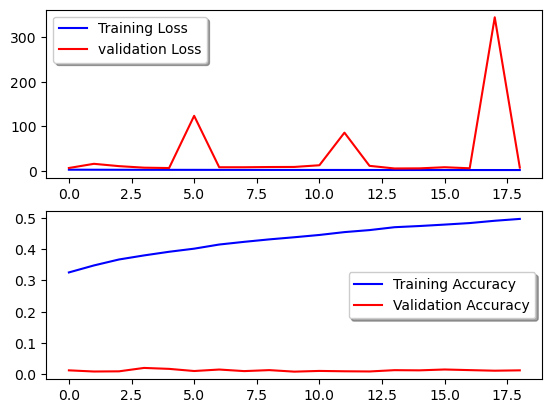

In [41]:
# Show Loss and Accuracy Plots
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation Loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [12]:
# Evaluate model on validation data
_, evaluation_score = model.evaluate(X_test, y_test)
print(f'Evaluation Score: {int(evaluation_score * 100)} %')

94/94 [==============================] - 1s 13ms/step - loss: 12.2518 - accuracy: 0.0117
Evaluation Score: 1 %


In [13]:
# Get classification report
pred = np.argmax(model.predict(X_test), axis=1)
test_y = np.argmax(y_test, axis=1)

print(classification_report(test_y, pred, labels=list(range(len(labels)))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00        40
           9       0.00      0.00      0.00        28
          10       0.00      0.00      0.00        29
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00        35
          14       0.00      0.00      0.00        28
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00        29
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
